In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
!pip install sentence_transformers

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import spacy
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.optim as optim
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset, Dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.metrics import f1_score
#from sklearn.metrics import classification_report
import pickle

In [201]:
#Reading csv file
train = pd.read_csv("/content/drive/MyDrive/DL_DialogDataset/train.csv")
test = pd.read_csv("/content/drive/MyDrive/DL_DialogDataset/test.csv")
train

,utterance,act
0,"Say , Jim , how about going for a few beers af...",3
1,You know that is tempting but is really not g...,4
2,What do you mean ? It will help us to relax .,2
3,Do you really think so ? I don't . It will ju...,2
4,I guess you are right.But what shall we do ? ...,2
...,...,...
5085,Tom and Helen got married at last .,1
5086,How did you know that ? I heart Tom ’ s fathe...,2
5087,I was invited to attend their wedding .,1
5088,It ’ s great . Although his father didn ’ t a...,1


In [214]:
Xtrain = train.utterance
ytrain = train.act - 1 
Xtest = test.utterance
ytest = test.act - 1
  

In [203]:
Xtrain

0       Say , Jim , how about going for a few beers af...
1        You know that is tempting but is really not g...
2          What do you mean ? It will help us to relax . 
3        Do you really think so ? I don't . It will ju...
4        I guess you are right.But what shall we do ? ...
                              ...                        
5085                 Tom and Helen got married at last . 
5086     How did you know that ? I heart Tom ’ s fathe...
5087             I was invited to attend their wedding . 
5088     It ’ s great . Although his father didn ’ t a...
5089                                How moving love is . 
Name: utterance, Length: 5090, dtype: object

In [33]:
np.random.seed(0)
torch.manual_seed(0)
# random.seed(0)

## Data Visualization

In [34]:
!pip install wordcloud

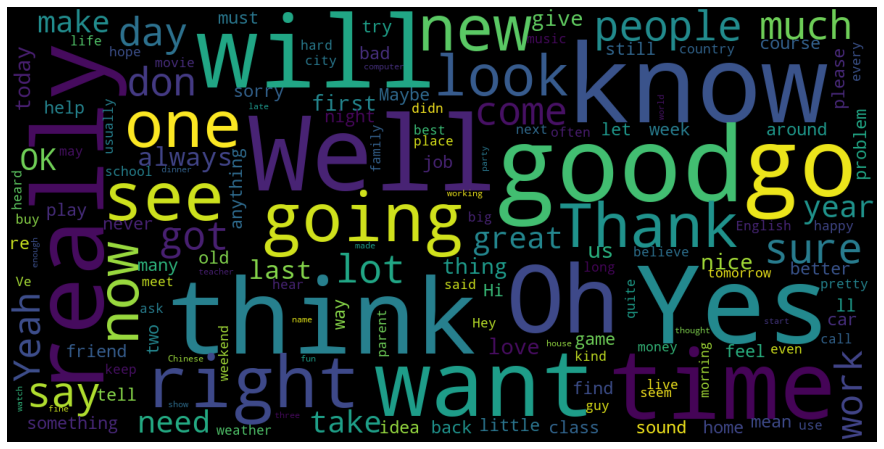

In [35]:
from wordcloud import WordCloud
# Display the world cloud
data = ' '.join(text for text in train['utterance'])
world_cloud = WordCloud(background_color='black',max_words=150,max_font_size=50,scale=3,random_state=1, collocations=False).generate(data)
plt.figure(figsize = (100,8))
plt.axis('off')
plt.imshow(world_cloud)

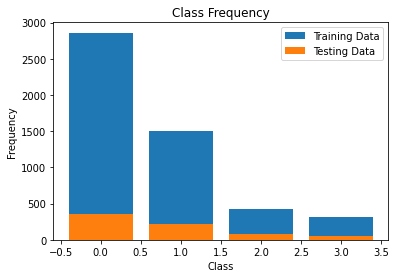

In [36]:

unique, counts = np.unique(ytrain, return_counts=True)
plt.bar(unique, counts,label="Training Data")
unique, counts = np.unique(ytest, return_counts=True)
plt.bar(unique, counts,label="Testing Data")
plt.legend()

plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')

plt.show()

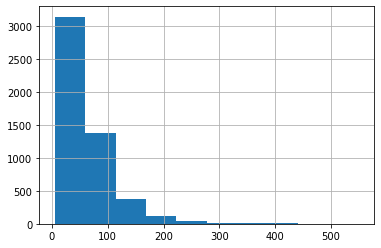

In [37]:
Xtrain.str.len().hist()

## Preprocessing

In [38]:
!pip install contractions 

In [39]:
# Xtrain2 = []
# ytrain2 = []
# Xtest2 = []
# ytest2 = []
# for i in tqdm(range(0, len(Xtrain))):
#     newStr = ""
#     # Xtrain2.append( Xtrain[i-4] + ' '+Xtrain[i-3] + ' '+Xtrain[i-2] + ' '+Xtrain[i-1] + ' ' + Xtrain[i])
#     # Xtrain2.append(Xtrain[i-2] + ' '+Xtrain[i-1] + ' ' + Xtrain[i])
#     # Xtrain2.append(Xtrain[i-1] + ' ' + Xtrain[i])
#     Xtrain2.append(Xtrain[i])
#     ytrain2.append(ytrain[i])
# # for i in tqdm(range(1, len(Xtest))):
# #     Xtest2.append(Xtest[i-1] + ' ' + Xtest[i])
# #     ytest2.append(ytest[i])

# max_seq_len = len(max(Xtrain2, key=len))

In [40]:

def lowerCase(df):
  for i in range(len(df)):
    df[i] = df[i].lower()
  return df


In [41]:
import contractions

def contractionExpand(df):
  for i in range(len(df)):
    df[i] = contractions.fix(df[i])
  return df
  # return contractions.fix(text)


In [42]:
import nltk
nltk.download('punkt')

def tokenize(df):
  for i in range(len(df)):
    df[i] = nltk.word_tokenize(df[i])
  return df
 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [43]:
Xtrain

0       Say , Jim , how about going for a few beers af...
1        You know that is tempting but is really not g...
2          What do you mean ? It will help us to relax . 
3        Do you really think so ? I don't . It will ju...
4        I guess you are right.But what shall we do ? ...
                              ...                        
5085                 Tom and Helen got married at last . 
5086     How did you know that ? I heart Tom ’ s fathe...
5087             I was invited to attend their wedding . 
5088     It ’ s great . Although his father didn ’ t a...
5089                                How moving love is . 
Name: utterance, Length: 5090, dtype: object

In [44]:
Xtest

0                 I'm better now . Want to play again ? 
1              I'll let you break the balls this time . 
2          Let's get all the balls out of the pockets . 
3       OK . How much do you want to bet on this game ? 
4       You are crazy . Gambling is against my princi...
                             ...                        
717     Yeah , I got to eat as much pizza as I could ...
718                             Did you like the play ? 
719     Not really . It's a dull one , and the produc...
720     You're absolutely right . The acting could be...
721     To be fair , though , both the costumes and s...
Name: utterance, Length: 722, dtype: object

In [204]:
def preprocessing(x):
  x = lowerCase(x)
  x = contractionExpand(x)
  x = tokenize(x)
  return x

Xtrain = preprocessing(Xtrain)
Xtest = preprocessing(Xtest)





/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [46]:
# max_seq_len = len(max(Xtrain, key=len))
# max_seq_len = len(max(Xtrain2, key=len))

### Sentence Embedding for each utterance: Using Bert sentence transformer

In [47]:
def modelSave(model,fileName):
  with open(fileName, 'wb') as file:
      
    # A new file will be created
    pickle.dump(model, file)

def modelLoad(fileName):
  with open(fileName, 'rb') as f:
    model = pickle.load(f)
  return model

In [205]:
Xtrain = [[' '.join(i)] for i in Xtrain]
Xtrain = [i[0] for i in Xtrain]
Xtest = [[' '.join(i)] for i in Xtest]
Xtest = [i[0] for i in Xtest]

In [49]:
sbert_model = SentenceTransformer('all-mpnet-base-v2')

In [50]:
train_sentence_embeddings = sbert_model.encode(Xtrain)
np.save("/content/drive/MyDrive/DL_DialogDataset/TrainEmbeddings",train_sentence_embeddings)
# train_sentence_embeddings = np.load("/content/drive/MyDrive/DL_DialogDataset/TrainEmbeddings.npy")
test_sentence_embeddings = sbert_model.encode(Xtest)

In [51]:
train_sentence_embeddings.shape, test_sentence_embeddings.shape

((5090, 768), (722, 768))

In [52]:
test_sentence_embeddings = np.array(test_sentence_embeddings)

In [206]:
# X = 5  #x-1 prev utterances
def prep_data(X):
  Xtrain_context = np.zeros((len(train_sentence_embeddings)-X+1,X,train_sentence_embeddings.shape[1]))

  for i in range(len(train_sentence_embeddings)-X-1):
    k = 0
    for j in range(i,i+X):
      Xtrain_context[i][k] = train_sentence_embeddings[j]
      # Xtrain_context[i][k] = Xtrain_context[i][k].astype('int')
      # Xtrain_context[i][k] = [int(l) for l in Xtrain_context[i][k]]
      k+=1

  Xtest_context = np.zeros((len(test_sentence_embeddings)-X+1,X,test_sentence_embeddings.shape[1]))

  for i in range(len(test_sentence_embeddings)-X-1):
    k = 0
    for j in range(i,i+X):
      Xtest_context[i][k] = test_sentence_embeddings[j]
      # Xtrain_context[i][k] = Xtrain_context[i][k].astype('int')
      # Xtrain_context[i][k] = [int(l) for l in Xtrain_context[i][k]]
      k+=1

  # Xtrain_context = Xtrain_context.astype('int')
  ytrain_context = np.array(ytrain)
  ytrain_context = ytrain_context[X-1:]
  train_data = TensorDataset(torch.from_numpy(Xtrain_context), torch.from_numpy(ytrain_context))
  trainDataLoader = DataLoader(train_data,batch_size=32)
  ytest_context = np.array(ytest)
  ytest_context = ytest_context[X-1:]
  test_data = TensorDataset(torch.from_numpy(Xtest_context), torch.from_numpy(ytest_context))
  testDataLoader = DataLoader(test_data, batch_size=32)
  return trainDataLoader,testDataLoader, ytest_context




In [54]:
test_sentence_embeddings = np.array(test_sentence_embeddings)
# Xtest_id= np.vstack(Xtest_id).astype('int')
ytest = np.array(ytest)
test_data = TensorDataset(torch.from_numpy(test_sentence_embeddings), torch.from_numpy(ytest))

In [55]:
testDataLoader = DataLoader(test_data, batch_size=32)

In [56]:
class LSTMClass(nn.Module):
    def __init__(self,embedding_dim,hidden_size,num_layers,drop_prob):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.embedding_dim = embedding_dim
        # print(embedding_dim)
        self.lstm = nn.LSTM(input_size=self.embedding_dim,hidden_size=self.hidden_size,num_layers=self.num_layers,batch_first=True,bidirectional=False)
        self.dropout = nn.Dropout(drop_prob)
        self.linear = nn.Linear(hidden_size, 4)
        # self.softmax = nn.Softmax()
        

    def forward(self, x):
      # print(x.shape)
      hnot = torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(device)
      cnot = torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(device)
      out,_ = self.lstm(x,(hnot,cnot))
      out = out[:,-1,:]
      # print("lstm",out.shape)
      out = self.dropout(out)
      out = self.linear(out)
      # print("lin",out.shape)
      # out = self.softmax(out)
      return out

In [57]:
lstm = LSTMClass(train_sentence_embeddings.shape[1],8,1,0.5).to(device)
criterion = nn.CrossEntropyLoss()
# criterion = nn.L1Loss()
optimizer = optim.Adam(lstm.parameters(), lr=0.01)

In [58]:
def lossVsEpochPlot(Loss,color,label):
    """
    Plot the loss vs epoch plot
    trainLoss: train loss
    validLoss: test loss
    """
    plt.plot(Loss, color=color)
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel(label+" Loss")
    plt.title(label+ " Loss vs Epochs Plot")
#     plt.savefig("Plots/Ques2/part1/{}_lossVsEpochs.png".format(funtion))
    plt.show()


def accVsEpochPlot(trainAcc, testAcc):
    """
    Plot the accuracy vs epoch plot
    trainAcc: train accuracy
    validAcc: test accuracy
    """
    plt.plot(trainAcc, label="Train Accuracy", color="blue")
    plt.plot(testAcc, label="Test Accuracy", color="red")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs Epochs for ")
#     plt.savefig("Plots/Ques2/part1/{}_accVsEpochs.png".format(funtion))
    plt.show()

In [59]:
def AccReport(dataloader,flag,lstm,ytest):
  with torch.no_grad():
      nCorrect = 0
      nSamples = 0
      nClassCorrect = [0 for i in range(4)]
      nClassTotal = [0 for i in range(4)]
      yPred = []
    
          
      for i,data in tqdm(enumerate(dataloader)):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data
          inputs = inputs.to(device)
          # print("l",labels.shape)
          # print(labels)
          labels = labels.reshape((-1,)).to(device)
          # if(flag):
          #   inputs = torch.unsqueeze(inputs,1)
          # print("l",labels.shape)
          # print(labels)
          
          outputs = lstm(inputs.float())
          loss = criterion(outputs, labels)
          # outputs = torch.squeeze(outputs)
          # outputs = outputs.reshape((-1, 1))
          # print(outputs.shape)
          _, predictions = torch.max(outputs,1)
          # print(predictions)
          # print("l",labels)
          nSamples += labels.shape[0]
          # nCorrect += (predictions == labels).sum().item()
          for i in range(len(predictions)):
            if predictions[i] == labels[i]:
              nCorrect += 1
            yPred.append(predictions[i])
           

            



      
      acc = 100.0 * nCorrect / nSamples
      if(flag):
        print(f'Accuracy on test: {acc:.2f}')
        f1 = f1_score(ytest, yPred, average='weighted')
        print(f'fl score on test: {f1:.2f}')
      else:
        print(f'Accuracy on train: {acc:.2f}')
        
      return acc,yPred

    

In [86]:
def training(X,lstm):
  trainDataLoader,testDataLoader,ytest = prep_data(X)
  totalSteps = len(trainDataLoader)
  numEpochs = 5
  trainLossAll = []
  trainAccAll = []
  valLossAll = []
  valAccAll = []
  # X = 2  # X previous utterances for t th utterance


  for epoch in range(numEpochs):  # loop over the dataset multiple times

      running_loss = 0.0
      trainLoss = 0
      
      for i, data in tqdm(enumerate(trainDataLoader)):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data
          inputs = inputs.to(device)
          # print("l",labels.shape)
          # print(labels)
          labels = labels.reshape((-1,)).to(device)
          # print("l",labels.shape)
          # print(labels)
          # inputs = torch.squeeze(inputs,0)
          # print(inputs.shape)
          # print(inputs)
          # print(inputs.float().shape)
          outputs = lstm(inputs.float())
          
            
          # outputs = torch.squeeze(outputs)
          # outputs = outputs.reshape((-1, 1))
          # print(outputs.shape)
          loss = criterion(outputs, labels)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          trainLoss += loss.item()*inputs.size(0)
      
          lstm.eval()
          validLoss = 0
          for data, target in testDataLoader:
              data, target = data.to(device), target.to(device)
              # data = torch.unsqueeze(data,1)
              # print(data.shape)
              output = lstm(data.float())
              # print(target)
              loss = criterion(output, target)
              validLoss += loss.item()*data.size(0)
          
    

      
          if (i+1) % 10 == 0:
              print(f'Epoch {epoch + 1} / {numEpochs}, Step {i+1} / {totalSteps}, Loss: {loss.item():.4f}')
              # print(outputs)

      trainLoss = trainLoss/len(trainDataLoader.dataset)
      validLoss = validLoss/len(testDataLoader.dataset)
          
      trainAcc,f1Train = AccReport(trainDataLoader,False,lstm,ytest)
      trainLossAll.append(trainLoss)
      trainAccAll.append(trainAcc)
      valAcc,f1Val = AccReport(testDataLoader,True,lstm,ytest)
      valLossAll.append(validLoss)
      valAccAll.append(valAcc)


  print('Finished Training')
  return trainDataLoader,testDataLoader,trainLossAll,trainAccAll,valLossAll,valAccAll,ytest

In [61]:
def finalReport(ytest,lstm,trainDataLoader,testDataLoader,trainLossAll,valLossAll,trainAccAll, valAccAll):
  lossVsEpochPlot(trainLossAll, "blue","Training")
  lossVsEpochPlot(valLossAll, "red","Validation")
  trainAcc,yPred = AccReport(trainDataLoader,False,lstm,ytest)
  testAcc,yPred = AccReport(testDataLoader,True,lstm,ytest)
  accVsEpochPlot(trainAccAll, valAccAll)
  f1 = f1_score(ytest, yPred, average='weighted')
  print(f'fl score on test: {f1:.2f}')
  print(classification_report(ytest, yPred)) 
  testMaxAcc = max(valAccAll)
  max_i = valAccAll.index(testMaxAcc)
  trainMaxVal = trainAccAll[max_i]
  X_f1.append(f1)
  X_valacc.append(testAcc)
  X_trainacc.append(trainMaxVal)
  X_valMaxacc.append(testMaxAcc)
  return testAcc,f1



In [161]:
X_valacc = []
X_valMaxacc = []
X_trainacc = []
X_f1 = []

## X = 0

In [162]:
lstm = LSTMClass(train_sentence_embeddings.shape[1],8,1,0.5).to(device)
criterion = nn.CrossEntropyLoss()
# criterion = nn.L1Loss()
optimizer = optim.Adam(lstm.parameters(), lr=0.01)
trainDataLoader,testDataLoader,trainLossAll,trainAccAll,valLossAll,valAccAll,ytest_context = training(1,lstm)

15it [00:00, 45.28it/s]

Epoch 1 / 5, Step 10 / 160, Loss: 1.2772


25it [00:00, 43.22it/s]

Epoch 1 / 5, Step 20 / 160, Loss: 1.0925


35it [00:00, 44.26it/s]

Epoch 1 / 5, Step 30 / 160, Loss: 0.9742


45it [00:01, 44.26it/s]

Epoch 1 / 5, Step 40 / 160, Loss: 0.8652


55it [00:01, 43.44it/s]

Epoch 1 / 5, Step 50 / 160, Loss: 0.7532


65it [00:01, 43.40it/s]

Epoch 1 / 5, Step 60 / 160, Loss: 0.6460


75it [00:01, 42.77it/s]

Epoch 1 / 5, Step 70 / 160, Loss: 0.5943


85it [00:01, 42.46it/s]

Epoch 1 / 5, Step 80 / 160, Loss: 0.5413


95it [00:02, 42.27it/s]

Epoch 1 / 5, Step 90 / 160, Loss: 0.5488


105it [00:02, 43.11it/s]

Epoch 1 / 5, Step 100 / 160, Loss: 0.5537


115it [00:02, 42.52it/s]

Epoch 1 / 5, Step 110 / 160, Loss: 0.5311


125it [00:02, 42.94it/s]

Epoch 1 / 5, Step 120 / 160, Loss: 0.5750


135it [00:03, 41.53it/s]

Epoch 1 / 5, Step 130 / 160, Loss: 0.5173


145it [00:03, 43.30it/s]

Epoch 1 / 5, Step 140 / 160, Loss: 0.5241


155it [00:03, 42.94it/s]

Epoch 1 / 5, Step 150 / 160, Loss: 0.5379


160it [00:03, 43.07it/s]


Epoch 1 / 5, Step 160 / 160, Loss: 0.4866


160it [00:00, 894.20it/s]


Accuracy on train: 76.39


23it [00:00, 765.36it/s]


Accuracy on test: 71.61
fl score on test: 0.70


15it [00:00, 44.93it/s]

Epoch 2 / 5, Step 10 / 160, Loss: 0.4680


25it [00:00, 44.85it/s]

Epoch 2 / 5, Step 20 / 160, Loss: 0.4664


35it [00:00, 43.86it/s]

Epoch 2 / 5, Step 30 / 160, Loss: 0.4306


45it [00:01, 44.36it/s]

Epoch 2 / 5, Step 40 / 160, Loss: 0.4042


55it [00:01, 43.18it/s]

Epoch 2 / 5, Step 50 / 160, Loss: 0.4063


65it [00:01, 44.31it/s]

Epoch 2 / 5, Step 60 / 160, Loss: 0.3967


75it [00:01, 43.73it/s]

Epoch 2 / 5, Step 70 / 160, Loss: 0.3939


85it [00:01, 43.12it/s]

Epoch 2 / 5, Step 80 / 160, Loss: 0.3968


95it [00:02, 43.75it/s]

Epoch 2 / 5, Step 90 / 160, Loss: 0.4180


105it [00:02, 44.08it/s]

Epoch 2 / 5, Step 100 / 160, Loss: 0.4265


115it [00:02, 44.77it/s]

Epoch 2 / 5, Step 110 / 160, Loss: 0.4206


125it [00:02, 42.97it/s]

Epoch 2 / 5, Step 120 / 160, Loss: 0.4787


135it [00:03, 43.91it/s]

Epoch 2 / 5, Step 130 / 160, Loss: 0.4348


145it [00:03, 44.63it/s]

Epoch 2 / 5, Step 140 / 160, Loss: 0.4391


155it [00:03, 44.59it/s]

Epoch 2 / 5, Step 150 / 160, Loss: 0.4533


160it [00:03, 43.92it/s]


Epoch 2 / 5, Step 160 / 160, Loss: 0.4019


160it [00:00, 786.48it/s]


Accuracy on train: 80.10


23it [00:00, 624.79it/s]


Accuracy on test: 72.71
fl score on test: 0.71


15it [00:00, 44.00it/s]

Epoch 3 / 5, Step 10 / 160, Loss: 0.4007


25it [00:00, 43.73it/s]

Epoch 3 / 5, Step 20 / 160, Loss: 0.4101


35it [00:00, 42.24it/s]

Epoch 3 / 5, Step 30 / 160, Loss: 0.3720


45it [00:01, 42.45it/s]

Epoch 3 / 5, Step 40 / 160, Loss: 0.3526


55it [00:01, 43.48it/s]

Epoch 3 / 5, Step 50 / 160, Loss: 0.3662


65it [00:01, 44.17it/s]

Epoch 3 / 5, Step 60 / 160, Loss: 0.3638


75it [00:01, 44.04it/s]

Epoch 3 / 5, Step 70 / 160, Loss: 0.3634


85it [00:01, 43.60it/s]

Epoch 3 / 5, Step 80 / 160, Loss: 0.3752


95it [00:02, 44.10it/s]

Epoch 3 / 5, Step 90 / 160, Loss: 0.4081


105it [00:02, 44.45it/s]

Epoch 3 / 5, Step 100 / 160, Loss: 0.4110


115it [00:02, 44.81it/s]

Epoch 3 / 5, Step 110 / 160, Loss: 0.4077


125it [00:02, 43.63it/s]

Epoch 3 / 5, Step 120 / 160, Loss: 0.4809


135it [00:03, 42.08it/s]

Epoch 3 / 5, Step 130 / 160, Loss: 0.4385


145it [00:03, 42.62it/s]

Epoch 3 / 5, Step 140 / 160, Loss: 0.4366


155it [00:03, 43.98it/s]

Epoch 3 / 5, Step 150 / 160, Loss: 0.4440


160it [00:03, 43.50it/s]


Epoch 3 / 5, Step 160 / 160, Loss: 0.3862


160it [00:00, 795.20it/s]


Accuracy on train: 83.01


23it [00:00, 572.99it/s]


Accuracy on test: 73.96
fl score on test: 0.73


15it [00:00, 45.46it/s]

Epoch 4 / 5, Step 10 / 160, Loss: 0.3894


25it [00:00, 45.16it/s]

Epoch 4 / 5, Step 20 / 160, Loss: 0.4045


35it [00:00, 44.89it/s]

Epoch 4 / 5, Step 30 / 160, Loss: 0.3653


45it [00:01, 43.19it/s]

Epoch 4 / 5, Step 40 / 160, Loss: 0.3442


55it [00:01, 42.91it/s]

Epoch 4 / 5, Step 50 / 160, Loss: 0.3694


65it [00:01, 43.87it/s]

Epoch 4 / 5, Step 60 / 160, Loss: 0.3750


75it [00:01, 44.54it/s]

Epoch 4 / 5, Step 70 / 160, Loss: 0.3710


85it [00:01, 43.52it/s]

Epoch 4 / 5, Step 80 / 160, Loss: 0.3851


95it [00:02, 40.23it/s]

Epoch 4 / 5, Step 90 / 160, Loss: 0.4227


105it [00:02, 40.69it/s]

Epoch 4 / 5, Step 100 / 160, Loss: 0.4252


115it [00:02, 42.10it/s]

Epoch 4 / 5, Step 110 / 160, Loss: 0.4189


125it [00:02, 42.51it/s]

Epoch 4 / 5, Step 120 / 160, Loss: 0.5077


135it [00:03, 42.78it/s]

Epoch 4 / 5, Step 130 / 160, Loss: 0.4585


145it [00:03, 40.91it/s]

Epoch 4 / 5, Step 140 / 160, Loss: 0.4518


155it [00:03, 42.35it/s]

Epoch 4 / 5, Step 150 / 160, Loss: 0.4470


160it [00:03, 42.64it/s]


Epoch 4 / 5, Step 160 / 160, Loss: 0.3931


160it [00:00, 821.07it/s]


Accuracy on train: 85.40


23it [00:00, 684.28it/s]


Accuracy on test: 73.13
fl score on test: 0.72


15it [00:00, 46.39it/s]

Epoch 5 / 5, Step 10 / 160, Loss: 0.3898


25it [00:00, 45.81it/s]

Epoch 5 / 5, Step 20 / 160, Loss: 0.4080


35it [00:00, 44.34it/s]

Epoch 5 / 5, Step 30 / 160, Loss: 0.3703


45it [00:01, 43.86it/s]

Epoch 5 / 5, Step 40 / 160, Loss: 0.3464


55it [00:01, 42.78it/s]

Epoch 5 / 5, Step 50 / 160, Loss: 0.3825


65it [00:01, 43.81it/s]

Epoch 5 / 5, Step 60 / 160, Loss: 0.3965


75it [00:01, 44.36it/s]

Epoch 5 / 5, Step 70 / 160, Loss: 0.3886


85it [00:01, 43.65it/s]

Epoch 5 / 5, Step 80 / 160, Loss: 0.4035


95it [00:02, 41.19it/s]

Epoch 5 / 5, Step 90 / 160, Loss: 0.4411


105it [00:02, 42.99it/s]

Epoch 5 / 5, Step 100 / 160, Loss: 0.4446


115it [00:02, 43.92it/s]

Epoch 5 / 5, Step 110 / 160, Loss: 0.4290


125it [00:02, 44.36it/s]

Epoch 5 / 5, Step 120 / 160, Loss: 0.5229


135it [00:03, 42.89it/s]

Epoch 5 / 5, Step 130 / 160, Loss: 0.4716


145it [00:03, 43.59it/s]

Epoch 5 / 5, Step 140 / 160, Loss: 0.4691


155it [00:03, 44.51it/s]

Epoch 5 / 5, Step 150 / 160, Loss: 0.4522


160it [00:03, 43.65it/s]


Epoch 5 / 5, Step 160 / 160, Loss: 0.4055


160it [00:00, 838.48it/s]


Accuracy on train: 87.54


23it [00:00, 659.60it/s]

Accuracy on test: 72.71
fl score on test: 0.71
Finished Training


In [163]:
modelSave(lstm,"X0a")

No handles with labels found to put in legend.


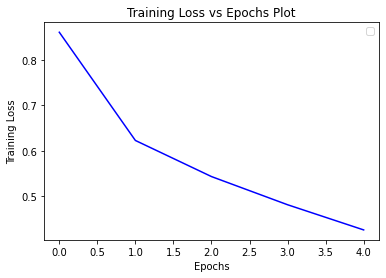

No handles with labels found to put in legend.


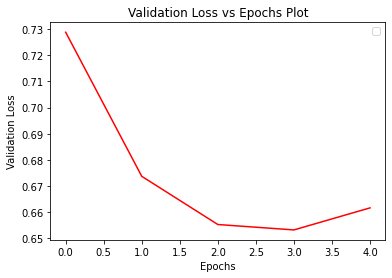

160it [00:00, 917.59it/s]


Accuracy on train: 87.54


23it [00:00, 683.29it/s]


Accuracy on test: 72.71
fl score on test: 0.71


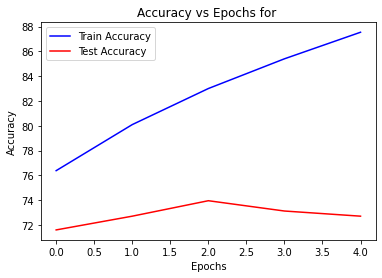

fl score on test: 0.71
              precision    recall  f1-score   support

           0       0.74      0.83      0.78       363
           1       0.77      0.82      0.79       217
           2       0.60      0.34      0.43        83
           3       0.49      0.31      0.38        59

    accuracy                           0.73       722
   macro avg       0.65      0.57      0.60       722
weighted avg       0.71      0.73      0.71       722



In [164]:
Acc,f1 = finalReport(ytest_context,lstm,trainDataLoader,testDataLoader,trainLossAll,valLossAll,trainAccAll, valAccAll)

In [215]:
lstm = modelLoad("X0a")
trainDataLoader,testDataLoader,ytest1 = prep_data(1)
a,b = AccReport(trainDataLoader,False,lstm,ytest1)
a,b = AccReport(testDataLoader,True,lstm,ytest1)

160it [00:00, 404.08it/s]


Accuracy on train: 87.54


23it [00:00, 441.44it/s]


Accuracy on test: 72.71
fl score on test: 0.71


## X = 1

In [166]:
lstm = LSTMClass(train_sentence_embeddings.shape[1],8,1,0.5).to(device)
criterion = nn.CrossEntropyLoss()
# criterion = nn.L1Loss()
optimizer = optim.Adam(lstm.parameters(), lr=0.01)
trainDataLoader,testDataLoader,trainLossAll,trainAccAll,valLossAll,valAccAll,ytest_context = training(2,lstm)

16it [00:00, 33.78it/s]

Epoch 1 / 5, Step 10 / 160, Loss: 1.2832


24it [00:00, 32.75it/s]

Epoch 1 / 5, Step 20 / 160, Loss: 1.1011


36it [00:01, 31.26it/s]

Epoch 1 / 5, Step 30 / 160, Loss: 1.0341


44it [00:01, 32.04it/s]

Epoch 1 / 5, Step 40 / 160, Loss: 0.9881


56it [00:01, 33.38it/s]

Epoch 1 / 5, Step 50 / 160, Loss: 0.9393


64it [00:01, 33.00it/s]

Epoch 1 / 5, Step 60 / 160, Loss: 0.8603


76it [00:02, 32.64it/s]

Epoch 1 / 5, Step 70 / 160, Loss: 0.7688


84it [00:02, 33.64it/s]

Epoch 1 / 5, Step 80 / 160, Loss: 0.6780


96it [00:02, 34.86it/s]

Epoch 1 / 5, Step 90 / 160, Loss: 0.6057


104it [00:03, 33.78it/s]

Epoch 1 / 5, Step 100 / 160, Loss: 0.6051


116it [00:03, 34.22it/s]

Epoch 1 / 5, Step 110 / 160, Loss: 0.5502


124it [00:03, 33.32it/s]

Epoch 1 / 5, Step 120 / 160, Loss: 0.5598


136it [00:04, 32.92it/s]

Epoch 1 / 5, Step 130 / 160, Loss: 0.4954


144it [00:04, 31.96it/s]

Epoch 1 / 5, Step 140 / 160, Loss: 0.4798


156it [00:04, 32.96it/s]

Epoch 1 / 5, Step 150 / 160, Loss: 0.4638


160it [00:04, 32.82it/s]


Epoch 1 / 5, Step 160 / 160, Loss: 0.4313


160it [00:00, 747.87it/s]


Accuracy on train: 76.62


23it [00:00, 687.11it/s]


Accuracy on test: 71.84
fl score on test: 0.69


16it [00:00, 33.91it/s]

Epoch 2 / 5, Step 10 / 160, Loss: 0.4497


24it [00:00, 33.81it/s]

Epoch 2 / 5, Step 20 / 160, Loss: 0.4223


36it [00:01, 32.59it/s]

Epoch 2 / 5, Step 30 / 160, Loss: 0.3911


44it [00:01, 33.29it/s]

Epoch 2 / 5, Step 40 / 160, Loss: 0.3822


56it [00:01, 34.30it/s]

Epoch 2 / 5, Step 50 / 160, Loss: 0.3728


64it [00:01, 34.34it/s]

Epoch 2 / 5, Step 60 / 160, Loss: 0.3759


76it [00:02, 33.66it/s]

Epoch 2 / 5, Step 70 / 160, Loss: 0.3442


84it [00:02, 33.60it/s]

Epoch 2 / 5, Step 80 / 160, Loss: 0.3531


96it [00:02, 34.14it/s]

Epoch 2 / 5, Step 90 / 160, Loss: 0.3524


104it [00:03, 33.73it/s]

Epoch 2 / 5, Step 100 / 160, Loss: 0.3640


116it [00:03, 34.16it/s]

Epoch 2 / 5, Step 110 / 160, Loss: 0.3352


124it [00:03, 34.52it/s]

Epoch 2 / 5, Step 120 / 160, Loss: 0.3681


136it [00:04, 33.73it/s]

Epoch 2 / 5, Step 130 / 160, Loss: 0.3505


144it [00:04, 33.36it/s]

Epoch 2 / 5, Step 140 / 160, Loss: 0.3754


156it [00:04, 34.28it/s]

Epoch 2 / 5, Step 150 / 160, Loss: 0.3731


160it [00:04, 33.49it/s]


Epoch 2 / 5, Step 160 / 160, Loss: 0.3253


160it [00:00, 718.56it/s]


Accuracy on train: 81.61


23it [00:00, 563.59it/s]


Accuracy on test: 75.17
fl score on test: 0.74


12it [00:00, 30.69it/s]

Epoch 3 / 5, Step 10 / 160, Loss: 0.3272


24it [00:00, 32.02it/s]

Epoch 3 / 5, Step 20 / 160, Loss: 0.3327


36it [00:01, 31.42it/s]

Epoch 3 / 5, Step 30 / 160, Loss: 0.2918


44it [00:01, 32.09it/s]

Epoch 3 / 5, Step 40 / 160, Loss: 0.2860


56it [00:01, 33.59it/s]

Epoch 3 / 5, Step 50 / 160, Loss: 0.2941


64it [00:01, 33.52it/s]

Epoch 3 / 5, Step 60 / 160, Loss: 0.3200


76it [00:02, 34.01it/s]

Epoch 3 / 5, Step 70 / 160, Loss: 0.2959


84it [00:02, 34.14it/s]

Epoch 3 / 5, Step 80 / 160, Loss: 0.3239


96it [00:02, 33.69it/s]

Epoch 3 / 5, Step 90 / 160, Loss: 0.3168


104it [00:03, 34.26it/s]

Epoch 3 / 5, Step 100 / 160, Loss: 0.3054


116it [00:03, 33.39it/s]

Epoch 3 / 5, Step 110 / 160, Loss: 0.2765


124it [00:03, 33.85it/s]

Epoch 3 / 5, Step 120 / 160, Loss: 0.3258


136it [00:04, 34.22it/s]

Epoch 3 / 5, Step 130 / 160, Loss: 0.3321


144it [00:04, 32.48it/s]

Epoch 3 / 5, Step 140 / 160, Loss: 0.3547


156it [00:04, 33.75it/s]

Epoch 3 / 5, Step 150 / 160, Loss: 0.3577


160it [00:04, 33.04it/s]


Epoch 3 / 5, Step 160 / 160, Loss: 0.2948


160it [00:00, 681.44it/s]


Accuracy on train: 85.44


23it [00:00, 618.48it/s]


Accuracy on test: 75.45
fl score on test: 0.74


16it [00:00, 34.83it/s]

Epoch 4 / 5, Step 10 / 160, Loss: 0.2712


24it [00:00, 33.24it/s]

Epoch 4 / 5, Step 20 / 160, Loss: 0.2786


36it [00:01, 33.58it/s]

Epoch 4 / 5, Step 30 / 160, Loss: 0.2522


44it [00:01, 33.32it/s]

Epoch 4 / 5, Step 40 / 160, Loss: 0.2443


56it [00:01, 34.25it/s]

Epoch 4 / 5, Step 50 / 160, Loss: 0.2499


64it [00:01, 34.12it/s]

Epoch 4 / 5, Step 60 / 160, Loss: 0.2904


76it [00:02, 33.78it/s]

Epoch 4 / 5, Step 70 / 160, Loss: 0.2786


84it [00:02, 32.99it/s]

Epoch 4 / 5, Step 80 / 160, Loss: 0.3020


96it [00:02, 32.51it/s]

Epoch 4 / 5, Step 90 / 160, Loss: 0.2831


104it [00:03, 33.14it/s]

Epoch 4 / 5, Step 100 / 160, Loss: 0.2815


112it [00:03, 30.47it/s]

Epoch 4 / 5, Step 110 / 160, Loss: 0.2584


124it [00:03, 32.79it/s]

Epoch 4 / 5, Step 120 / 160, Loss: 0.2886


136it [00:04, 34.57it/s]

Epoch 4 / 5, Step 130 / 160, Loss: 0.3050


144it [00:04, 34.09it/s]

Epoch 4 / 5, Step 140 / 160, Loss: 0.3557


156it [00:04, 34.39it/s]

Epoch 4 / 5, Step 150 / 160, Loss: 0.3537


160it [00:04, 33.28it/s]


Epoch 4 / 5, Step 160 / 160, Loss: 0.2948


160it [00:00, 725.51it/s]


Accuracy on train: 88.64


23it [00:00, 601.27it/s]


Accuracy on test: 75.45
fl score on test: 0.74


16it [00:00, 34.17it/s]

Epoch 5 / 5, Step 10 / 160, Loss: 0.2709


24it [00:00, 34.44it/s]

Epoch 5 / 5, Step 20 / 160, Loss: 0.2770


36it [00:01, 34.97it/s]

Epoch 5 / 5, Step 30 / 160, Loss: 0.2518


44it [00:01, 33.37it/s]

Epoch 5 / 5, Step 40 / 160, Loss: 0.2483


56it [00:01, 33.64it/s]

Epoch 5 / 5, Step 50 / 160, Loss: 0.2233


64it [00:01, 33.83it/s]

Epoch 5 / 5, Step 60 / 160, Loss: 0.2375


76it [00:02, 33.86it/s]

Epoch 5 / 5, Step 70 / 160, Loss: 0.2517


84it [00:02, 33.88it/s]

Epoch 5 / 5, Step 80 / 160, Loss: 0.2746


96it [00:02, 34.12it/s]

Epoch 5 / 5, Step 90 / 160, Loss: 0.2580


104it [00:03, 34.48it/s]

Epoch 5 / 5, Step 100 / 160, Loss: 0.2540


116it [00:03, 34.01it/s]

Epoch 5 / 5, Step 110 / 160, Loss: 0.2433


124it [00:03, 32.91it/s]

Epoch 5 / 5, Step 120 / 160, Loss: 0.2513


136it [00:04, 33.88it/s]

Epoch 5 / 5, Step 130 / 160, Loss: 0.2520


144it [00:04, 33.43it/s]

Epoch 5 / 5, Step 140 / 160, Loss: 0.3193


156it [00:04, 32.60it/s]

Epoch 5 / 5, Step 150 / 160, Loss: 0.3345


160it [00:04, 33.57it/s]


Epoch 5 / 5, Step 160 / 160, Loss: 0.2691


160it [00:00, 674.72it/s]


Accuracy on train: 91.26


23it [00:00, 568.93it/s]


Accuracy on test: 75.45
fl score on test: 0.74
Finished Training


In [167]:
modelSave(lstm,"X1a")

No handles with labels found to put in legend.


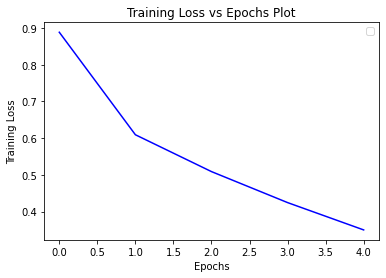

No handles with labels found to put in legend.


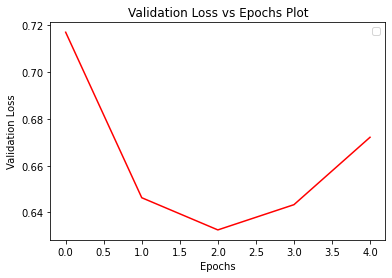

160it [00:00, 713.84it/s]


Accuracy on train: 91.26


23it [00:00, 610.18it/s]


Accuracy on test: 75.45
fl score on test: 0.74


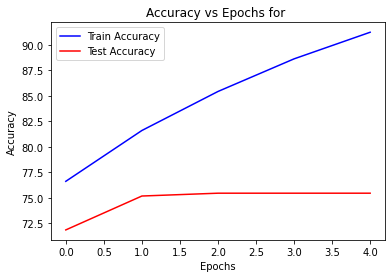

fl score on test: 0.74
              precision    recall  f1-score   support

           0       0.77      0.87      0.82       363
           1       0.79      0.77      0.78       217
           2       0.61      0.37      0.46        82
           3       0.61      0.51      0.56        59

    accuracy                           0.75       721
   macro avg       0.70      0.63      0.65       721
weighted avg       0.75      0.75      0.74       721



In [168]:
Acc,f1 = finalReport(ytest_context,lstm,trainDataLoader,testDataLoader,trainLossAll,valLossAll,trainAccAll, valAccAll)

In [216]:
lstm = modelLoad("X1a")
trainDataLoader,testDataLoader,ytest1 = prep_data(2)
a,b = AccReport(trainDataLoader,False,lstm,ytest1)
a,b = AccReport(testDataLoader,True,lstm,ytest1)

160it [00:00, 414.91it/s]


Accuracy on train: 91.26


23it [00:00, 426.16it/s]

Accuracy on test: 75.45
fl score on test: 0.74


## X = 2

In [169]:
lstm = LSTMClass(train_sentence_embeddings.shape[1],8,1,0.5).to(device)
criterion = nn.CrossEntropyLoss()
# criterion = nn.L1Loss()
optimizer = optim.Adam(lstm.parameters(), lr=0.01)
trainDataLoader,testDataLoader,trainLossAll,trainAccAll,valLossAll,valAccAll,ytest_context = training(3,lstm)

15it [00:00, 27.07it/s]

Epoch 1 / 5, Step 10 / 159, Loss: 1.2173


24it [00:00, 26.38it/s]

Epoch 1 / 5, Step 20 / 159, Loss: 1.0916


33it [00:01, 26.22it/s]

Epoch 1 / 5, Step 30 / 159, Loss: 0.9682


45it [00:01, 26.41it/s]

Epoch 1 / 5, Step 40 / 159, Loss: 0.9034


54it [00:02, 26.97it/s]

Epoch 1 / 5, Step 50 / 159, Loss: 0.8348


63it [00:02, 26.62it/s]

Epoch 1 / 5, Step 60 / 159, Loss: 0.6972


75it [00:02, 27.54it/s]

Epoch 1 / 5, Step 70 / 159, Loss: 0.5781


84it [00:03, 26.92it/s]

Epoch 1 / 5, Step 80 / 159, Loss: 0.5270


93it [00:03, 26.44it/s]

Epoch 1 / 5, Step 90 / 159, Loss: 0.4619


105it [00:03, 26.87it/s]

Epoch 1 / 5, Step 100 / 159, Loss: 0.4728


114it [00:04, 26.37it/s]

Epoch 1 / 5, Step 110 / 159, Loss: 0.4256


123it [00:04, 26.76it/s]

Epoch 1 / 5, Step 120 / 159, Loss: 0.4659


135it [00:05, 26.68it/s]

Epoch 1 / 5, Step 130 / 159, Loss: 0.3935


144it [00:05, 25.84it/s]

Epoch 1 / 5, Step 140 / 159, Loss: 0.3915


153it [00:05, 23.20it/s]

Epoch 1 / 5, Step 150 / 159, Loss: 0.4063


159it [00:06, 26.01it/s]
159it [00:00, 497.40it/s]


Accuracy on train: 75.31


23it [00:00, 545.46it/s]


Accuracy on test: 67.36
fl score on test: 0.61


15it [00:00, 27.44it/s]

Epoch 2 / 5, Step 10 / 159, Loss: 0.3789


24it [00:00, 26.77it/s]

Epoch 2 / 5, Step 20 / 159, Loss: 0.3600


33it [00:01, 27.49it/s]

Epoch 2 / 5, Step 30 / 159, Loss: 0.3109


45it [00:01, 26.50it/s]

Epoch 2 / 5, Step 40 / 159, Loss: 0.3363


51it [00:02, 19.34it/s]

Epoch 2 / 5, Step 50 / 159, Loss: 0.3364


62it [00:02, 15.31it/s]

Epoch 2 / 5, Step 60 / 159, Loss: 0.3080


71it [00:03, 16.22it/s]

Epoch 2 / 5, Step 70 / 159, Loss: 0.2985


85it [00:03, 23.02it/s]

Epoch 2 / 5, Step 80 / 159, Loss: 0.2991


94it [00:04, 26.02it/s]

Epoch 2 / 5, Step 90 / 159, Loss: 0.3161


103it [00:04, 27.47it/s]

Epoch 2 / 5, Step 100 / 159, Loss: 0.3658


115it [00:05, 25.61it/s]

Epoch 2 / 5, Step 110 / 159, Loss: 0.3152


124it [00:05, 26.51it/s]

Epoch 2 / 5, Step 120 / 159, Loss: 0.4039


133it [00:05, 26.01it/s]

Epoch 2 / 5, Step 130 / 159, Loss: 0.3417


145it [00:06, 26.79it/s]

Epoch 2 / 5, Step 140 / 159, Loss: 0.3422


154it [00:06, 27.38it/s]

Epoch 2 / 5, Step 150 / 159, Loss: 0.3733


159it [00:06, 23.57it/s]
159it [00:00, 570.33it/s]


Accuracy on train: 80.39


23it [00:00, 506.76it/s]


Accuracy on test: 73.61
fl score on test: 0.72


15it [00:00, 27.72it/s]

Epoch 3 / 5, Step 10 / 159, Loss: 0.3278


24it [00:00, 26.83it/s]

Epoch 3 / 5, Step 20 / 159, Loss: 0.3315


33it [00:01, 27.54it/s]

Epoch 3 / 5, Step 30 / 159, Loss: 0.2669


45it [00:01, 27.37it/s]

Epoch 3 / 5, Step 40 / 159, Loss: 0.2784


54it [00:01, 26.77it/s]

Epoch 3 / 5, Step 50 / 159, Loss: 0.2736


63it [00:02, 27.30it/s]

Epoch 3 / 5, Step 60 / 159, Loss: 0.2657


75it [00:02, 27.74it/s]

Epoch 3 / 5, Step 70 / 159, Loss: 0.2437


84it [00:03, 25.44it/s]

Epoch 3 / 5, Step 80 / 159, Loss: 0.2468


93it [00:03, 24.17it/s]

Epoch 3 / 5, Step 90 / 159, Loss: 0.2691


105it [00:03, 25.36it/s]

Epoch 3 / 5, Step 100 / 159, Loss: 0.2918


114it [00:04, 26.67it/s]

Epoch 3 / 5, Step 110 / 159, Loss: 0.2534


123it [00:04, 24.21it/s]

Epoch 3 / 5, Step 120 / 159, Loss: 0.3409


135it [00:05, 26.65it/s]

Epoch 3 / 5, Step 130 / 159, Loss: 0.2938


144it [00:05, 27.33it/s]

Epoch 3 / 5, Step 140 / 159, Loss: 0.3014


153it [00:05, 26.05it/s]

Epoch 3 / 5, Step 150 / 159, Loss: 0.3274


159it [00:06, 26.38it/s]
159it [00:00, 531.98it/s]


Accuracy on train: 85.02


23it [00:00, 528.37it/s]


Accuracy on test: 75.97
fl score on test: 0.75


15it [00:00, 27.63it/s]

Epoch 4 / 5, Step 10 / 159, Loss: 0.2438


24it [00:00, 27.14it/s]

Epoch 4 / 5, Step 20 / 159, Loss: 0.2604


33it [00:01, 27.50it/s]

Epoch 4 / 5, Step 30 / 159, Loss: 0.2140


45it [00:01, 27.01it/s]

Epoch 4 / 5, Step 40 / 159, Loss: 0.2126


54it [00:01, 26.50it/s]

Epoch 4 / 5, Step 50 / 159, Loss: 0.2277


63it [00:02, 26.63it/s]

Epoch 4 / 5, Step 60 / 159, Loss: 0.2272


75it [00:02, 26.19it/s]

Epoch 4 / 5, Step 70 / 159, Loss: 0.1910


84it [00:03, 26.94it/s]

Epoch 4 / 5, Step 80 / 159, Loss: 0.1971


93it [00:03, 27.23it/s]

Epoch 4 / 5, Step 90 / 159, Loss: 0.2154


105it [00:03, 26.73it/s]

Epoch 4 / 5, Step 100 / 159, Loss: 0.2299


114it [00:04, 27.11it/s]

Epoch 4 / 5, Step 110 / 159, Loss: 0.2108


123it [00:04, 26.85it/s]

Epoch 4 / 5, Step 120 / 159, Loss: 0.2416


135it [00:05, 26.43it/s]

Epoch 4 / 5, Step 130 / 159, Loss: 0.2333


144it [00:05, 26.05it/s]

Epoch 4 / 5, Step 140 / 159, Loss: 0.2702


153it [00:05, 27.02it/s]

Epoch 4 / 5, Step 150 / 159, Loss: 0.3202


159it [00:05, 26.69it/s]
159it [00:00, 601.51it/s]


Accuracy on train: 88.80


23it [00:00, 607.16it/s]


Accuracy on test: 75.14
fl score on test: 0.74


15it [00:00, 26.58it/s]

Epoch 5 / 5, Step 10 / 159, Loss: 0.2033


24it [00:00, 26.90it/s]

Epoch 5 / 5, Step 20 / 159, Loss: 0.1925


33it [00:01, 27.41it/s]

Epoch 5 / 5, Step 30 / 159, Loss: 0.1915


45it [00:01, 26.80it/s]

Epoch 5 / 5, Step 40 / 159, Loss: 0.2015


54it [00:02, 26.29it/s]

Epoch 5 / 5, Step 50 / 159, Loss: 0.2210


63it [00:02, 27.27it/s]

Epoch 5 / 5, Step 60 / 159, Loss: 0.2260


75it [00:02, 27.09it/s]

Epoch 5 / 5, Step 70 / 159, Loss: 0.1664


84it [00:03, 27.14it/s]

Epoch 5 / 5, Step 80 / 159, Loss: 0.1527


93it [00:03, 27.05it/s]

Epoch 5 / 5, Step 90 / 159, Loss: 0.1833


102it [00:03, 26.68it/s]

Epoch 5 / 5, Step 100 / 159, Loss: 0.2026


114it [00:04, 26.69it/s]

Epoch 5 / 5, Step 110 / 159, Loss: 0.1929


123it [00:04, 27.37it/s]

Epoch 5 / 5, Step 120 / 159, Loss: 0.1786


135it [00:05, 26.66it/s]

Epoch 5 / 5, Step 130 / 159, Loss: 0.2006


144it [00:05, 26.39it/s]

Epoch 5 / 5, Step 140 / 159, Loss: 0.2674


153it [00:05, 24.82it/s]

Epoch 5 / 5, Step 150 / 159, Loss: 0.2671


159it [00:05, 26.57it/s]
159it [00:00, 607.01it/s]


Accuracy on train: 91.94


23it [00:00, 524.87it/s]

Accuracy on test: 75.97
fl score on test: 0.75
Finished Training


In [170]:
modelSave(lstm,"X2a")

No handles with labels found to put in legend.


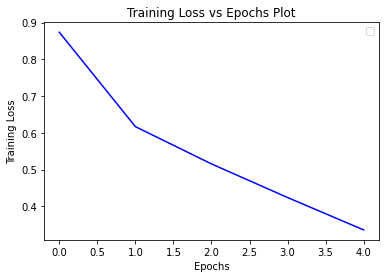

No handles with labels found to put in legend.


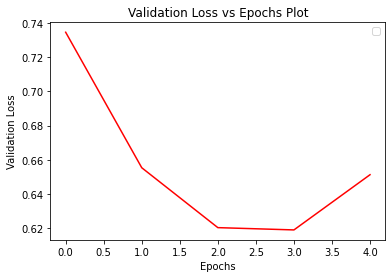

159it [00:00, 579.25it/s]


Accuracy on train: 91.94


23it [00:00, 445.37it/s]


Accuracy on test: 75.97
fl score on test: 0.75


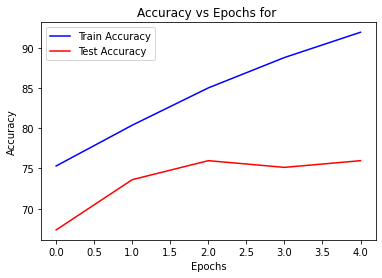

fl score on test: 0.75
              precision    recall  f1-score   support

           0       0.81      0.83      0.82       363
           1       0.75      0.82      0.78       217
           2       0.60      0.46      0.52        82
           3       0.67      0.52      0.58        58

    accuracy                           0.76       720
   macro avg       0.71      0.66      0.68       720
weighted avg       0.75      0.76      0.75       720



In [171]:
Acc,f1 = finalReport(ytest_context,lstm,trainDataLoader,testDataLoader,trainLossAll,valLossAll,trainAccAll, valAccAll)

In [218]:
lstm = modelLoad("X2a")
trainDataLoader,testDataLoader,ytest1 = prep_data(3)
a,b = AccReport(trainDataLoader,False,lstm,ytest1)
a,b = AccReport(testDataLoader,True,lstm,ytest1)

159it [00:00, 335.44it/s]


Accuracy on train: 91.94


23it [00:00, 280.91it/s]

Accuracy on test: 75.97
fl score on test: 0.75


## X = 3

In [172]:
lstm = LSTMClass(train_sentence_embeddings.shape[1],8,1,0.5).to(device)
criterion = nn.CrossEntropyLoss()
# criterion = nn.L1Loss()
optimizer = optim.Adam(lstm.parameters(), lr=0.01)
trainDataLoader,testDataLoader,trainLossAll,trainAccAll,valLossAll,valAccAll,ytest_context = training(4,lstm)

12it [00:00, 23.75it/s]

Epoch 1 / 5, Step 10 / 159, Loss: 1.0914


24it [00:01, 22.99it/s]

Epoch 1 / 5, Step 20 / 159, Loss: 0.9972


33it [00:01, 23.25it/s]

Epoch 1 / 5, Step 30 / 159, Loss: 0.9026


42it [00:01, 23.78it/s]

Epoch 1 / 5, Step 40 / 159, Loss: 0.9134


54it [00:02, 23.11it/s]

Epoch 1 / 5, Step 50 / 159, Loss: 0.8989


63it [00:02, 24.06it/s]

Epoch 1 / 5, Step 60 / 159, Loss: 0.8513


72it [00:03, 23.08it/s]

Epoch 1 / 5, Step 70 / 159, Loss: 0.8079


84it [00:03, 23.85it/s]

Epoch 1 / 5, Step 80 / 159, Loss: 0.7781


93it [00:03, 24.28it/s]

Epoch 1 / 5, Step 90 / 159, Loss: 0.7601


105it [00:04, 23.96it/s]

Epoch 1 / 5, Step 100 / 159, Loss: 0.7437


114it [00:04, 23.85it/s]

Epoch 1 / 5, Step 110 / 159, Loss: 0.6980


123it [00:05, 24.16it/s]

Epoch 1 / 5, Step 120 / 159, Loss: 0.6726


132it [00:05, 23.51it/s]

Epoch 1 / 5, Step 130 / 159, Loss: 0.5845


144it [00:06, 23.41it/s]

Epoch 1 / 5, Step 140 / 159, Loss: 0.5502


153it [00:06, 24.26it/s]

Epoch 1 / 5, Step 150 / 159, Loss: 0.4836


159it [00:06, 23.60it/s]
159it [00:00, 517.91it/s]


Accuracy on train: 74.74


23it [00:00, 386.27it/s]


Accuracy on test: 69.82
fl score on test: 0.66


12it [00:00, 24.49it/s]

Epoch 2 / 5, Step 10 / 159, Loss: 0.4475


24it [00:00, 23.64it/s]

Epoch 2 / 5, Step 20 / 159, Loss: 0.4282


33it [00:01, 24.42it/s]

Epoch 2 / 5, Step 30 / 159, Loss: 0.3638


45it [00:01, 24.55it/s]

Epoch 2 / 5, Step 40 / 159, Loss: 0.3624


54it [00:02, 24.31it/s]

Epoch 2 / 5, Step 50 / 159, Loss: 0.4014


63it [00:02, 23.99it/s]

Epoch 2 / 5, Step 60 / 159, Loss: 0.3794


72it [00:02, 23.75it/s]

Epoch 2 / 5, Step 70 / 159, Loss: 0.3408


84it [00:03, 24.07it/s]

Epoch 2 / 5, Step 80 / 159, Loss: 0.3683


93it [00:03, 22.24it/s]

Epoch 2 / 5, Step 90 / 159, Loss: 0.3445


105it [00:04, 23.86it/s]

Epoch 2 / 5, Step 100 / 159, Loss: 0.3678


114it [00:04, 24.50it/s]

Epoch 2 / 5, Step 110 / 159, Loss: 0.3459


123it [00:05, 23.18it/s]

Epoch 2 / 5, Step 120 / 159, Loss: 0.4129


132it [00:05, 23.86it/s]

Epoch 2 / 5, Step 130 / 159, Loss: 0.3634


144it [00:06, 23.67it/s]

Epoch 2 / 5, Step 140 / 159, Loss: 0.3640


153it [00:06, 24.28it/s]

Epoch 2 / 5, Step 150 / 159, Loss: 0.4068


159it [00:06, 23.83it/s]
159it [00:00, 547.40it/s]


Accuracy on train: 80.60


23it [00:00, 405.91it/s]


Accuracy on test: 74.69
fl score on test: 0.73


15it [00:00, 24.93it/s]

Epoch 3 / 5, Step 10 / 159, Loss: 0.3089


24it [00:01, 23.17it/s]

Epoch 3 / 5, Step 20 / 159, Loss: 0.3616


33it [00:01, 21.77it/s]

Epoch 3 / 5, Step 30 / 159, Loss: 0.3050


42it [00:01, 21.67it/s]

Epoch 3 / 5, Step 40 / 159, Loss: 0.2888


54it [00:02, 22.86it/s]

Epoch 3 / 5, Step 50 / 159, Loss: 0.3263


63it [00:02, 23.47it/s]

Epoch 3 / 5, Step 60 / 159, Loss: 0.3230


72it [00:03, 23.65it/s]

Epoch 3 / 5, Step 70 / 159, Loss: 0.2858


81it [00:03, 21.47it/s]

Epoch 3 / 5, Step 80 / 159, Loss: 0.3061


93it [00:04, 22.75it/s]

Epoch 3 / 5, Step 90 / 159, Loss: 0.2804


102it [00:04, 23.01it/s]

Epoch 3 / 5, Step 100 / 159, Loss: 0.2764


114it [00:05, 22.54it/s]

Epoch 3 / 5, Step 110 / 159, Loss: 0.2656


123it [00:05, 23.63it/s]

Epoch 3 / 5, Step 120 / 159, Loss: 0.3093


135it [00:05, 24.12it/s]

Epoch 3 / 5, Step 130 / 159, Loss: 0.2889


144it [00:06, 23.64it/s]

Epoch 3 / 5, Step 140 / 159, Loss: 0.2896


153it [00:06, 24.03it/s]

Epoch 3 / 5, Step 150 / 159, Loss: 0.3286


159it [00:06, 23.02it/s]
159it [00:00, 488.19it/s]


Accuracy on train: 84.23


23it [00:00, 537.94it/s]


Accuracy on test: 76.91
fl score on test: 0.76


12it [00:00, 24.10it/s]

Epoch 4 / 5, Step 10 / 159, Loss: 0.2378


24it [00:00, 23.83it/s]

Epoch 4 / 5, Step 20 / 159, Loss: 0.2726


33it [00:01, 24.34it/s]

Epoch 4 / 5, Step 30 / 159, Loss: 0.2398


42it [00:01, 24.22it/s]

Epoch 4 / 5, Step 40 / 159, Loss: 0.2194


54it [00:02, 23.97it/s]

Epoch 4 / 5, Step 50 / 159, Loss: 0.2445


63it [00:02, 23.74it/s]

Epoch 4 / 5, Step 60 / 159, Loss: 0.2645


72it [00:03, 23.61it/s]

Epoch 4 / 5, Step 70 / 159, Loss: 0.2433


84it [00:03, 22.90it/s]

Epoch 4 / 5, Step 80 / 159, Loss: 0.2581


93it [00:03, 23.21it/s]

Epoch 4 / 5, Step 90 / 159, Loss: 0.2445


102it [00:04, 23.32it/s]

Epoch 4 / 5, Step 100 / 159, Loss: 0.2398


114it [00:04, 23.55it/s]

Epoch 4 / 5, Step 110 / 159, Loss: 0.2368


123it [00:05, 23.28it/s]

Epoch 4 / 5, Step 120 / 159, Loss: 0.2643


132it [00:05, 23.32it/s]

Epoch 4 / 5, Step 130 / 159, Loss: 0.2634


144it [00:06, 22.81it/s]

Epoch 4 / 5, Step 140 / 159, Loss: 0.2710


153it [00:06, 23.28it/s]

Epoch 4 / 5, Step 150 / 159, Loss: 0.2956


159it [00:06, 23.46it/s]
159it [00:00, 486.43it/s]


Accuracy on train: 87.75


23it [00:00, 433.74it/s]


Accuracy on test: 77.19
fl score on test: 0.76


14it [00:00, 21.42it/s]

Epoch 5 / 5, Step 10 / 159, Loss: 0.2215


23it [00:01, 22.23it/s]

Epoch 5 / 5, Step 20 / 159, Loss: 0.2417


32it [00:01, 23.62it/s]

Epoch 5 / 5, Step 30 / 159, Loss: 0.2159


44it [00:01, 23.73it/s]

Epoch 5 / 5, Step 40 / 159, Loss: 0.2009


53it [00:02, 23.65it/s]

Epoch 5 / 5, Step 50 / 159, Loss: 0.2142


65it [00:02, 24.30it/s]

Epoch 5 / 5, Step 60 / 159, Loss: 0.2457


74it [00:03, 23.52it/s]

Epoch 5 / 5, Step 70 / 159, Loss: 0.2431


83it [00:03, 24.18it/s]

Epoch 5 / 5, Step 80 / 159, Loss: 0.2511


92it [00:03, 23.93it/s]

Epoch 5 / 5, Step 90 / 159, Loss: 0.2381


104it [00:04, 24.28it/s]

Epoch 5 / 5, Step 100 / 159, Loss: 0.2294


113it [00:04, 24.24it/s]

Epoch 5 / 5, Step 110 / 159, Loss: 0.2320


122it [00:05, 23.84it/s]

Epoch 5 / 5, Step 120 / 159, Loss: 0.2313


134it [00:05, 24.59it/s]

Epoch 5 / 5, Step 130 / 159, Loss: 0.2412


143it [00:06, 24.45it/s]

Epoch 5 / 5, Step 140 / 159, Loss: 0.2593


155it [00:06, 24.59it/s]

Epoch 5 / 5, Step 150 / 159, Loss: 0.2577


159it [00:06, 23.72it/s]
159it [00:00, 554.78it/s]


Accuracy on train: 89.99


23it [00:00, 445.61it/s]

Accuracy on test: 76.77
fl score on test: 0.75
Finished Training


In [173]:
modelSave(lstm,"X3a")

No handles with labels found to put in legend.


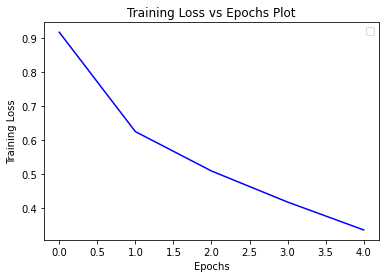

No handles with labels found to put in legend.


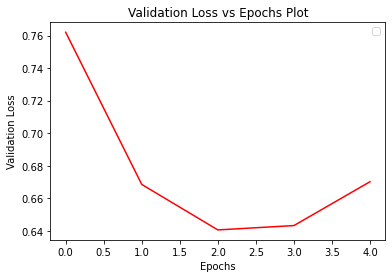

159it [00:00, 559.54it/s]


Accuracy on train: 89.99


23it [00:00, 522.07it/s]


Accuracy on test: 76.77
fl score on test: 0.75


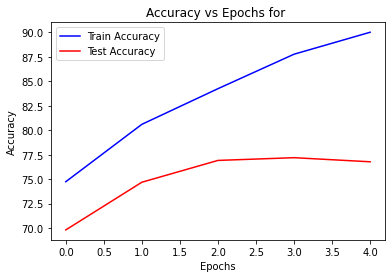

fl score on test: 0.75
              precision    recall  f1-score   support

           0       0.76      0.90      0.82       363
           1       0.78      0.80      0.79       217
           2       0.76      0.32      0.45        81
           3       0.74      0.48      0.58        58

    accuracy                           0.77       719
   macro avg       0.76      0.62      0.66       719
weighted avg       0.77      0.77      0.75       719



In [174]:
Acc,f1 = finalReport(ytest_context,lstm,trainDataLoader,testDataLoader,trainLossAll,valLossAll,trainAccAll, valAccAll)

In [219]:
lstm = modelLoad("X3a")
trainDataLoader,testDataLoader,ytest1 = prep_data(4)
a,b = AccReport(trainDataLoader,False,lstm,ytest1)
a,b = AccReport(testDataLoader,True,lstm,ytest1)

159it [00:00, 347.01it/s]


Accuracy on train: 89.99


23it [00:00, 305.34it/s]

Accuracy on test: 76.77
fl score on test: 0.75


## X = 4

In [175]:
lstm = LSTMClass(train_sentence_embeddings.shape[1],8,1,0.5).to(device)
criterion = nn.CrossEntropyLoss()
# criterion = nn.L1Loss()
optimizer = optim.Adam(lstm.parameters(), lr=0.01)
trainDataLoader,testDataLoader,trainLossAll,trainAccAll,valLossAll,valAccAll,ytest_context = training(5,lstm)

12it [00:00, 20.28it/s]

Epoch 1 / 5, Step 10 / 159, Loss: 1.2868


24it [00:01, 20.55it/s]

Epoch 1 / 5, Step 20 / 159, Loss: 1.0709


33it [00:01, 20.81it/s]

Epoch 1 / 5, Step 30 / 159, Loss: 0.9585


42it [00:02, 20.28it/s]

Epoch 1 / 5, Step 40 / 159, Loss: 0.9062


53it [00:02, 18.26it/s]

Epoch 1 / 5, Step 50 / 159, Loss: 0.8420


63it [00:03, 19.65it/s]

Epoch 1 / 5, Step 60 / 159, Loss: 0.7522


72it [00:03, 21.05it/s]

Epoch 1 / 5, Step 70 / 159, Loss: 0.6729


84it [00:04, 21.19it/s]

Epoch 1 / 5, Step 80 / 159, Loss: 0.6110


93it [00:04, 21.54it/s]

Epoch 1 / 5, Step 90 / 159, Loss: 0.5308


102it [00:05, 20.91it/s]

Epoch 1 / 5, Step 100 / 159, Loss: 0.4853


114it [00:05, 21.35it/s]

Epoch 1 / 5, Step 110 / 159, Loss: 0.4356


123it [00:06, 20.96it/s]

Epoch 1 / 5, Step 120 / 159, Loss: 0.4687


132it [00:06, 21.10it/s]

Epoch 1 / 5, Step 130 / 159, Loss: 0.4321


144it [00:07, 21.19it/s]

Epoch 1 / 5, Step 140 / 159, Loss: 0.4524


153it [00:07, 21.17it/s]

Epoch 1 / 5, Step 150 / 159, Loss: 0.4346


159it [00:07, 20.61it/s]
159it [00:00, 478.59it/s]


Accuracy on train: 75.21


23it [00:00, 464.41it/s]


Accuracy on test: 67.41
fl score on test: 0.62


12it [00:00, 20.68it/s]

Epoch 2 / 5, Step 10 / 159, Loss: 0.3620


24it [00:01, 21.31it/s]

Epoch 2 / 5, Step 20 / 159, Loss: 0.3425


33it [00:01, 21.53it/s]

Epoch 2 / 5, Step 30 / 159, Loss: 0.3078


42it [00:01, 21.14it/s]

Epoch 2 / 5, Step 40 / 159, Loss: 0.2895


54it [00:02, 21.89it/s]

Epoch 2 / 5, Step 50 / 159, Loss: 0.3051


63it [00:02, 21.29it/s]

Epoch 2 / 5, Step 60 / 159, Loss: 0.2943


72it [00:03, 21.16it/s]

Epoch 2 / 5, Step 70 / 159, Loss: 0.2734


84it [00:03, 21.74it/s]

Epoch 2 / 5, Step 80 / 159, Loss: 0.3004


93it [00:04, 21.43it/s]

Epoch 2 / 5, Step 90 / 159, Loss: 0.3017


102it [00:04, 21.27it/s]

Epoch 2 / 5, Step 100 / 159, Loss: 0.3470


114it [00:05, 21.38it/s]

Epoch 2 / 5, Step 110 / 159, Loss: 0.2932


123it [00:05, 21.66it/s]

Epoch 2 / 5, Step 120 / 159, Loss: 0.3646


132it [00:06, 21.48it/s]

Epoch 2 / 5, Step 130 / 159, Loss: 0.3398


144it [00:06, 20.79it/s]

Epoch 2 / 5, Step 140 / 159, Loss: 0.3612


153it [00:07, 21.37it/s]

Epoch 2 / 5, Step 150 / 159, Loss: 0.3891


159it [00:07, 21.29it/s]
159it [00:00, 462.10it/s]


Accuracy on train: 80.36


23it [00:00, 457.52it/s]


Accuracy on test: 72.42
fl score on test: 0.71


12it [00:00, 22.19it/s]

Epoch 3 / 5, Step 10 / 159, Loss: 0.2862


24it [00:01, 21.96it/s]

Epoch 3 / 5, Step 20 / 159, Loss: 0.2935


33it [00:01, 22.17it/s]

Epoch 3 / 5, Step 30 / 159, Loss: 0.2358


42it [00:01, 20.98it/s]

Epoch 3 / 5, Step 40 / 159, Loss: 0.2148


54it [00:02, 21.55it/s]

Epoch 3 / 5, Step 50 / 159, Loss: 0.2543


63it [00:02, 21.00it/s]

Epoch 3 / 5, Step 60 / 159, Loss: 0.2638


72it [00:03, 21.12it/s]

Epoch 3 / 5, Step 70 / 159, Loss: 0.2398


84it [00:03, 21.44it/s]

Epoch 3 / 5, Step 80 / 159, Loss: 0.2839


93it [00:04, 21.47it/s]

Epoch 3 / 5, Step 90 / 159, Loss: 0.2676


102it [00:04, 21.62it/s]

Epoch 3 / 5, Step 100 / 159, Loss: 0.2985


114it [00:05, 21.58it/s]

Epoch 3 / 5, Step 110 / 159, Loss: 0.2532


123it [00:05, 21.94it/s]

Epoch 3 / 5, Step 120 / 159, Loss: 0.3405


132it [00:06, 21.73it/s]

Epoch 3 / 5, Step 130 / 159, Loss: 0.3126


144it [00:06, 21.63it/s]

Epoch 3 / 5, Step 140 / 159, Loss: 0.3215


153it [00:07, 21.29it/s]

Epoch 3 / 5, Step 150 / 159, Loss: 0.3330


159it [00:07, 21.51it/s]
159it [00:00, 461.56it/s]


Accuracy on train: 84.15


23it [00:00, 468.12it/s]


Accuracy on test: 74.51
fl score on test: 0.74


13it [00:00, 20.32it/s]

Epoch 4 / 5, Step 10 / 159, Loss: 0.2609


22it [00:01, 21.03it/s]

Epoch 4 / 5, Step 20 / 159, Loss: 0.2984


34it [00:01, 21.08it/s]

Epoch 4 / 5, Step 30 / 159, Loss: 0.2152


43it [00:02, 21.26it/s]

Epoch 4 / 5, Step 40 / 159, Loss: 0.1727


52it [00:02, 21.23it/s]

Epoch 4 / 5, Step 50 / 159, Loss: 0.2045


64it [00:03, 20.83it/s]

Epoch 4 / 5, Step 60 / 159, Loss: 0.2204


73it [00:03, 21.19it/s]

Epoch 4 / 5, Step 70 / 159, Loss: 0.1650


82it [00:03, 20.87it/s]

Epoch 4 / 5, Step 80 / 159, Loss: 0.2048


94it [00:04, 21.47it/s]

Epoch 4 / 5, Step 90 / 159, Loss: 0.1920


103it [00:04, 21.16it/s]

Epoch 4 / 5, Step 100 / 159, Loss: 0.2067


112it [00:05, 20.90it/s]

Epoch 4 / 5, Step 110 / 159, Loss: 0.1850


124it [00:05, 21.06it/s]

Epoch 4 / 5, Step 120 / 159, Loss: 0.2724


133it [00:06, 21.43it/s]

Epoch 4 / 5, Step 130 / 159, Loss: 0.2825


142it [00:06, 21.47it/s]

Epoch 4 / 5, Step 140 / 159, Loss: 0.2845


154it [00:07, 21.68it/s]

Epoch 4 / 5, Step 150 / 159, Loss: 0.2663


159it [00:07, 20.99it/s]
159it [00:00, 483.56it/s]


Accuracy on train: 87.51


23it [00:00, 408.47it/s]


Accuracy on test: 76.04
fl score on test: 0.76


12it [00:00, 21.86it/s]

Epoch 5 / 5, Step 10 / 159, Loss: 0.2217


24it [00:01, 21.36it/s]

Epoch 5 / 5, Step 20 / 159, Loss: 0.2734


33it [00:01, 21.14it/s]

Epoch 5 / 5, Step 30 / 159, Loss: 0.1624


42it [00:01, 20.88it/s]

Epoch 5 / 5, Step 40 / 159, Loss: 0.1205


54it [00:02, 21.60it/s]

Epoch 5 / 5, Step 50 / 159, Loss: 0.1348


63it [00:02, 20.57it/s]

Epoch 5 / 5, Step 60 / 159, Loss: 0.1374


72it [00:03, 20.73it/s]

Epoch 5 / 5, Step 70 / 159, Loss: 0.1176


84it [00:04, 20.74it/s]

Epoch 5 / 5, Step 80 / 159, Loss: 0.1329


93it [00:04, 21.03it/s]

Epoch 5 / 5, Step 90 / 159, Loss: 0.1336


102it [00:04, 20.97it/s]

Epoch 5 / 5, Step 100 / 159, Loss: 0.1271


114it [00:05, 21.61it/s]

Epoch 5 / 5, Step 110 / 159, Loss: 0.1074


123it [00:05, 22.03it/s]

Epoch 5 / 5, Step 120 / 159, Loss: 0.1721


132it [00:06, 21.61it/s]

Epoch 5 / 5, Step 130 / 159, Loss: 0.2168


144it [00:06, 21.91it/s]

Epoch 5 / 5, Step 140 / 159, Loss: 0.2395


153it [00:07, 21.23it/s]

Epoch 5 / 5, Step 150 / 159, Loss: 0.2116


159it [00:07, 21.16it/s]
159it [00:00, 462.17it/s]


Accuracy on train: 89.89


23it [00:00, 371.16it/s]

Accuracy on test: 76.04
fl score on test: 0.76
Finished Training


In [176]:
modelSave(lstm,"X4a")

No handles with labels found to put in legend.


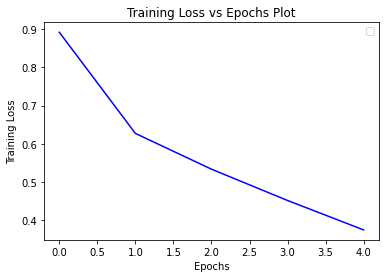

No handles with labels found to put in legend.


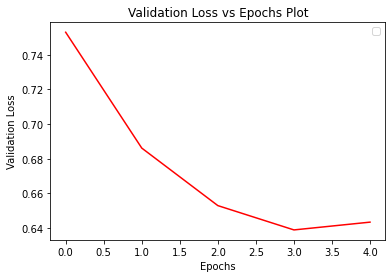

159it [00:00, 487.12it/s]


Accuracy on train: 89.89


23it [00:00, 503.58it/s]


Accuracy on test: 76.04
fl score on test: 0.76


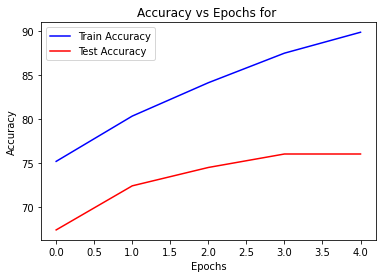

fl score on test: 0.76
              precision    recall  f1-score   support

           0       0.80      0.84      0.82       363
           1       0.80      0.76      0.78       216
           2       0.58      0.51      0.54        81
           3       0.57      0.60      0.59        58

    accuracy                           0.76       718
   macro avg       0.69      0.68      0.68       718
weighted avg       0.76      0.76      0.76       718



In [177]:
Acc,f1 = finalReport(ytest_context,lstm,trainDataLoader,testDataLoader,trainLossAll,valLossAll,trainAccAll, valAccAll)

In [220]:
lstm = modelLoad("X4a")
trainDataLoader,testDataLoader,ytest1 = prep_data(5)
a,b = AccReport(trainDataLoader,False,lstm,ytest1)
a,b = AccReport(testDataLoader,True,lstm,ytest1)

159it [00:00, 272.58it/s]


Accuracy on train: 89.89


23it [00:00, 138.42it/s]


Accuracy on test: 76.04
fl score on test: 0.76


In [178]:
def plotForX(data,color,yLabel):
  plt.plot(data, color=color)
  plt.xlabel("X")
  plt.ylabel(yLabel)
  plt.title(yLabel + " vs X ")
  plt.show()

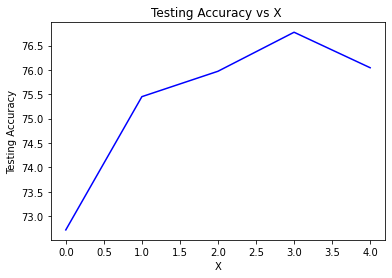

In [179]:
plotForX(X_valacc,"blue","Testing Accuracy")

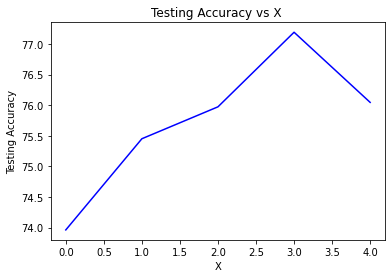

In [180]:
plotForX(X_valMaxacc,"blue","Testing Accuracy")

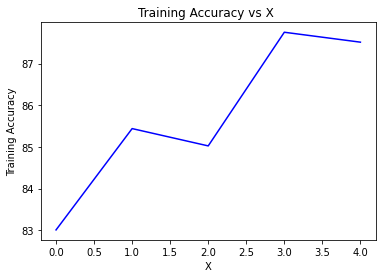

In [181]:
plotForX(X_trainacc,"blue","Training Accuracy")

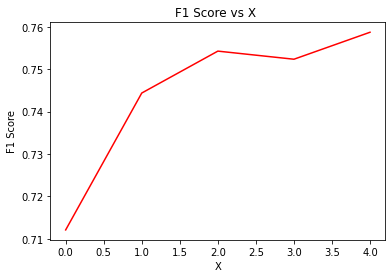

In [182]:
plotForX(X_f1,"red","F1 Score")

Dataloader for taking only previous x utterances (Sliding window --> if x utterances to be considered send x+1 samples at a time (x+1 is window size)) 

### Sentence Embedding for each utterance: Using Glove and then pooling

In [185]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip
!ls -lat

--2022-04-06 15:04:32--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-04-06 15:04:32--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-04-06 15:04:33--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [186]:
vocab,embeddings = [],[]
with open('glove.6B.50d.txt','rt') as fi:
    full_content = fi.read().strip().split('\n')
for i in range(len(full_content)):
    i_word = full_content[i].split(' ')[0]
    i_embeddings = [float(val) for val in full_content[i].split(' ')[1:]]
    vocab.append(i_word)
    embeddings.append(i_embeddings)

vocab_npa = np.array(vocab)
embs_npa = np.array(embeddings)




In [187]:
#insert '<pad>' and '<unk>' tokens at start of vocab_npa.
vocab_npa = np.insert(vocab_npa, 0, '<pad>')
vocab_npa = np.insert(vocab_npa, 1, '<unk>')
print(vocab_npa[:10])

pad_emb_npa = np.zeros((1,embs_npa.shape[1]))   #embedding for '<pad>' token.
unk_emb_npa = np.mean(embs_npa,axis=0,keepdims=True)    #embedding for '<unk>' token.

#insert embeddings for pad and unk tokens at top of embs_npa.
embs_npa = np.vstack((pad_emb_npa,unk_emb_npa,embs_npa))
print(embs_npa.shape)

['<pad>' '<unk>' 'the' ',' '.' 'of' 'to' 'and' 'in' 'a']
(400002, 50)


In [188]:
max_seq_len = len(max(Xtrain, key=len))

In [193]:
#Reading csv file
train = pd.read_csv("/content/drive/MyDrive/DL_DialogDataset/train.csv")
test = pd.read_csv("/content/drive/MyDrive/DL_DialogDataset/test.csv")
Xtrain = train.utterance
ytrain = train.act - 1 
Xtest = test.utterance
ytest = test.act - 1
Xtrain = preprocessing(Xtrain)
Xtest = preprocessing(Xtest)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [194]:
def convert_text_to_id(df,vocab,unk_token,pad_to_len,pad_token):
  word2idx = {term:idx for idx,term in enumerate(vocab)}
  idx2word = {idx:word for word,idx in word2idx.items()}

  for i in range(len(df)):
    deficit = pad_to_len - len(df[i])
    df[i].extend([pad_token]*deficit)
    for j in range(len(df[i])):
      if df[i][j] not in word2idx:
        df[i][j] = word2idx[unk_token]
      else:
        df[i][j] = word2idx[df[i][j]]
  return df


Xtrain_id = convert_text_to_id(Xtrain,vocab_npa,'<unk>',max_seq_len,'<pad>')

In [195]:
Xtest_id = convert_text_to_id(Xtest,vocab_npa,'<unk>',max_seq_len,'<pad>')

In [196]:
class LSTMGloveClass(nn.Module):
    def __init__(self,embs_nps,hidden_size,num_layers,drop_prob):
        super().__init__()
        self.vocab_size = embs_npa.shape[0]
        self.embedding_dim = embs_npa.shape[1]
        self.embedding = nn.Embedding.from_pretrained(torch.from_numpy(embs_npa).float(),freeze=True)
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.pool = nn.AdaptiveAvgPool2d((1,self.embedding_dim))
        self.lstm = nn.LSTM(input_size=self.embedding_dim,hidden_size=self.hidden_size,num_layers=self.num_layers,batch_first=True,bidirectional=False)
        self.dropout = nn.Dropout(drop_prob)
        self.linear = nn.Linear(hidden_size, 4)
        # self.softmax = nn.Softmax()
        

    def forward(self, x):
      embed_out = self.embedding(x)
      # print("emb",embed_out.shape)
      sentence_embed_out = self.pool(embed_out)
      sentence_embed_out = torch.squeeze(sentence_embed_out,2)
      # print("Senemb",sentence_embed_out.shape)
      hnot = torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(device)
      cnot = torch.zeros(self.num_layers,x.size(0),self.hidden_size).to(device)
      out,_ = self.lstm(sentence_embed_out,(hnot,cnot))
      out = out[:,-1,:]
      # print("lstm",out.shape)
      out = self.dropout(out)
      out = self.linear(out)
      # print("lin",out.shape)
      # out = self.softmax(out)
      return out

In [197]:
X_acc_glove = []
X_f1_glove = []

# X = 0

In [198]:
lstm = LSTMGloveClass(train_sentence_embeddings.shape[1],8,1,0.5).to(device)
criterion = nn.CrossEntropyLoss()
# criterion = nn.L1Loss()
optimizer = optim.Adam(lstm.parameters(), lr=0.01)
trainDataLoader,testDataLoader,trainLossAll,trainAccAll,valLossAll,valAccAll,ytest_context = training(1,lstm)

0it [00:00, ?it/s]


RuntimeError: ignored